In [1]:
import numpy as np
import pandas as pd
import os

from tensorflow import keras
import tensorflow as tf

import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr

In [2]:
def mse(y_true, y_pred):
    return np.mean(np.square(y_true[:,3]-y_pred[:,3]))
def mae(y_true, y_pred):
    return np.mean(np.abs((y_true[:,3]-y_pred[:,3])))
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true[:,3]-y_pred[:,3])/y_true[:,3]))
def rmse(y_true, y_pred):
    return np.sqrt(np.mean(tf.square(y_true[:,3]-y_pred[:,3])))
def ar(y_true, y_pred):
    mask = tf.cast(y_pred[1:,3] > y_true[:-1,3],tf.float32)
    return np.mean((y_true[1:,3]-y_true[:-1,3])*mask)

In [3]:
def add_Ma(df, window=5):
    for i in range(window, df.shape[0]):
        sum = 0.0
        for k in range(1, window+1):
            sum += df.iloc[i-k, 4]
        df.loc[df.index[i], 'Ma'] = np.round(sum/window, 6)
    return df[window:]

In [4]:
def createDataset(dataset, look_back, n_features):
    dataX = np.zeros([len(dataset)-look_back, look_back, n_features])
    dataY = np.zeros([len(dataset)-look_back, n_features])
    data = dataset.drop(columns='Date').to_numpy()
    for i in range(0, len(data)-look_back):
        dataX[i] = data[i:i+look_back]
        dataY[i] = data[i+look_back]
    mean = dataX.mean(axis=1)
    std = dataX.std(axis=1)
    dataX = (dataX - mean[:,None,:])/std[:,None,:]
    dataY = (dataY - mean)/std
    return dataX, dataY, mean, std
def plot_frame(sequence, target, mean, std, model):
    y_pred = model.predict(sequence)
    y_pred_real = y_pred*std + mean
    y_true = target
    y_true_real = y_true*std + mean
    
    plt.figure()
    plt.title("closing price")
    plt.plot(y_true_real[...,3], label="true")
    plt.plot(y_pred_real[...,3], label="prediction")
    plt.legend()
    plt.show()
    return y_pred_real, y_true_real

In [5]:
look_back=5
n_sequence = look_back
n_features = 7
stock_code = "AAPL"
start = dt.datetime(2019, 1, 1)
end = dt.datetime(2021, 12, 31)
raw_data = pdr.get_data_yahoo(stock_code, start, end)
df = raw_data.dropna();
df = df.reset_index(level=0)
df = add_Ma(df, look_back)
df

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,Ma
5,2019-01-09,37.822498,38.632500,37.407501,38.327499,36.936375,180396400,37.352499
6,2019-01-10,38.125000,38.492500,37.715000,38.450001,37.054436,143122800,37.121999
7,2019-01-11,38.220001,38.424999,37.877499,38.072498,36.690632,108092800,37.702499
8,2019-01-14,37.712502,37.817501,37.305000,37.500000,36.138912,129756800,37.903999
9,2019-01-15,37.567501,38.347500,37.512501,38.267502,36.878559,114843600,38.007500
...,...,...,...,...,...,...,...,...
751,2021-12-23,175.850006,176.850006,175.270004,176.279999,174.995621,68356600,172.356000
752,2021-12-27,177.089996,180.419998,177.070007,180.330002,179.016113,74919600,173.160001
753,2021-12-28,180.160004,181.330002,178.529999,179.289993,177.983688,79144300,174.998001
754,2021-12-29,179.330002,180.630005,178.139999,179.380005,178.073044,62348900,176.906000


In [11]:
def load_file(file_name):
    x, y, mean, std = createDataset(df, look_back, n_features)
    generator = keras.models.load_model(file_name, custom_objects={"mse": mse , "mae": mae, "mape": mape, "rmse": rmse, "ar": ar})
    
    y_pred = generator.predict(x)
    y_pred_real = y_pred*std + mean
    y_true = y
    y_true_real = y_true*std + mean

    plt.figure()
    plt.title("Closing price - {0}".format(file_name))
    plt.plot(y_true_real[...,3], label="true")
    plt.plot(y_pred_real[...,3], label="prediction")
    plt.legend()
    plt.show()
    
    row = [mse(y_true_real, y_pred_real), mae(y_true_real, y_pred_real), mape(y_true_real, y_pred_real), rmse(y_true_real, y_pred_real), ar(y_true_real, y_pred_real)]
    return row

(751, 7)
24/24 [==============================] - 0s 2ms/step


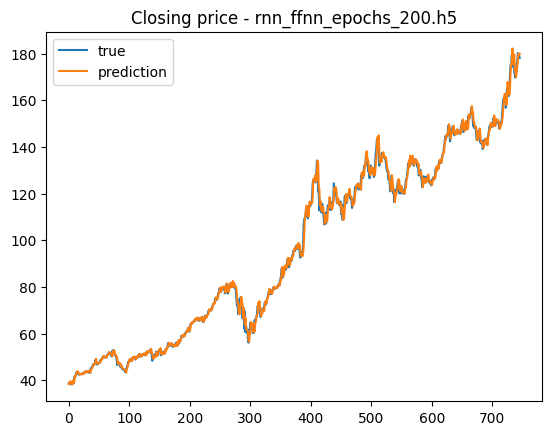

(751, 7)
24/24 [==============================] - 0s 2ms/step


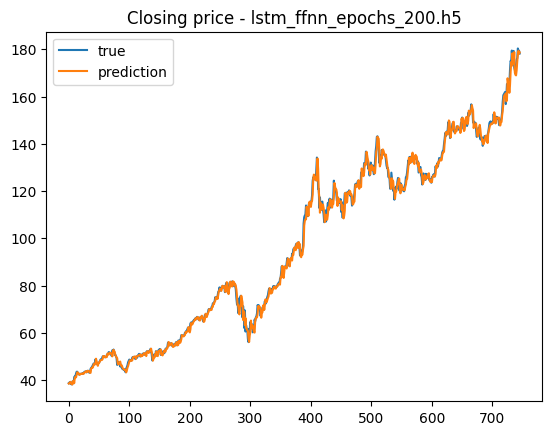

(751, 7)
24/24 [==============================] - 1s 2ms/step


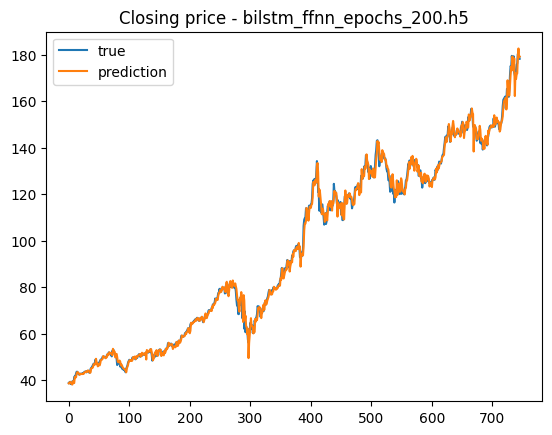

(751, 7)
24/24 [==============================] - 0s 2ms/step


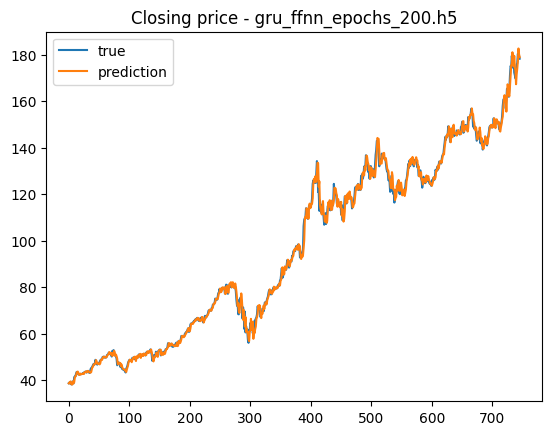

(751, 7)
24/24 [==============================] - 0s 2ms/step


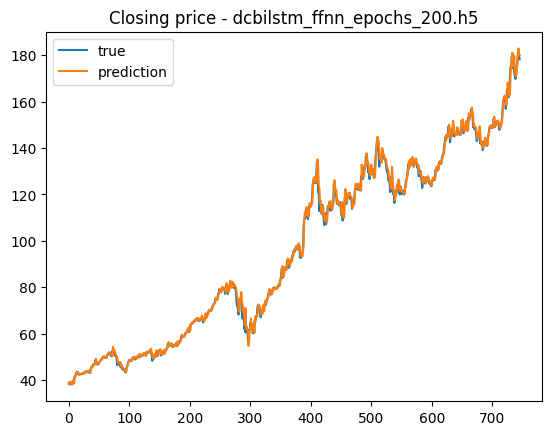

(751, 7)
24/24 [==============================] - 0s 2ms/step


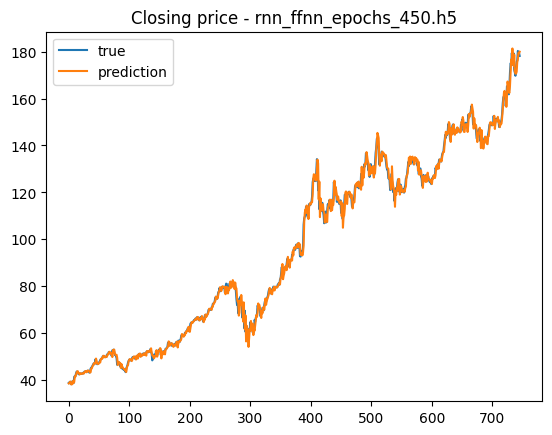

(751, 7)
24/24 [==============================] - 0s 2ms/step


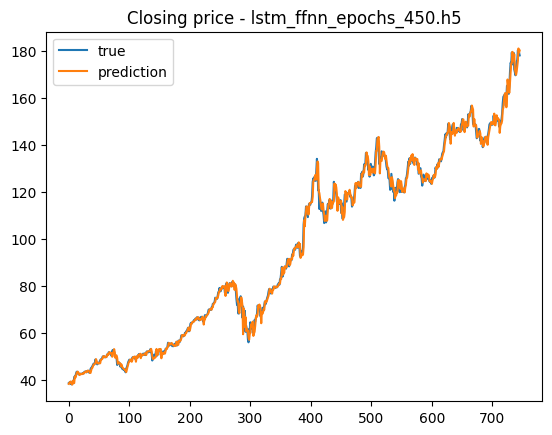

(751, 7)
24/24 [==============================] - 0s 2ms/step


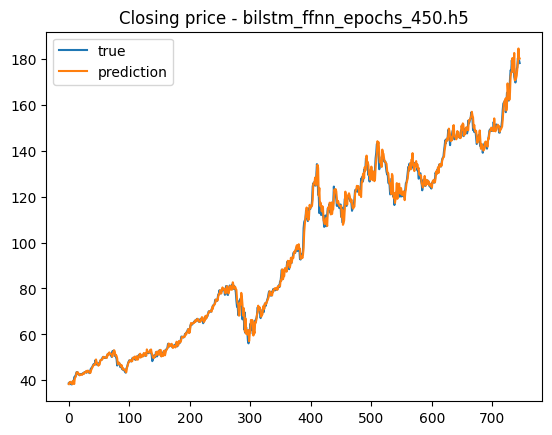

(751, 7)
24/24 [==============================] - 0s 2ms/step


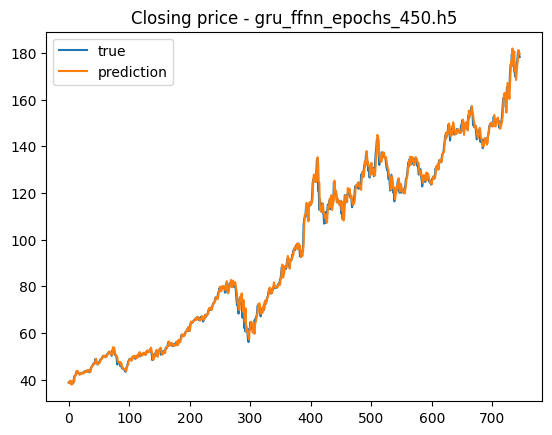

(751, 7)
24/24 [==============================] - 0s 2ms/step


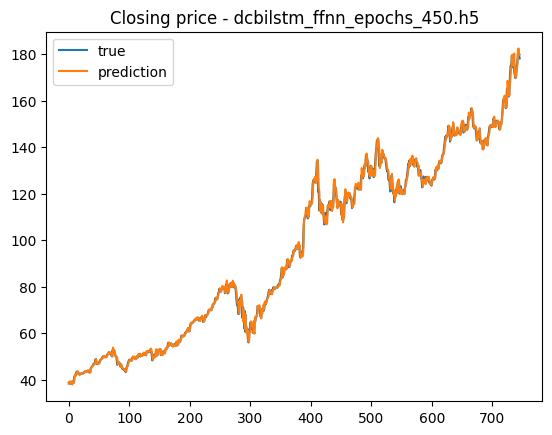

(751, 7)
24/24 [==============================] - 0s 2ms/step


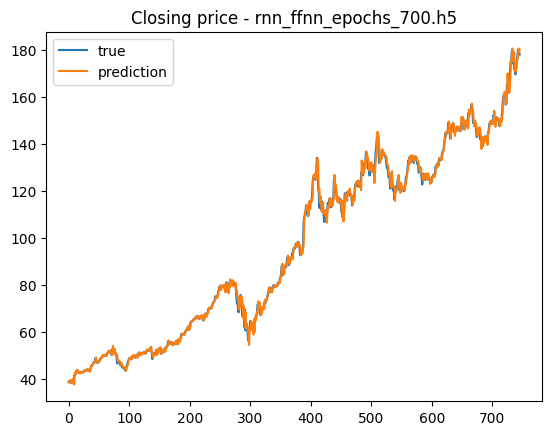

(751, 7)
24/24 [==============================] - 0s 2ms/step


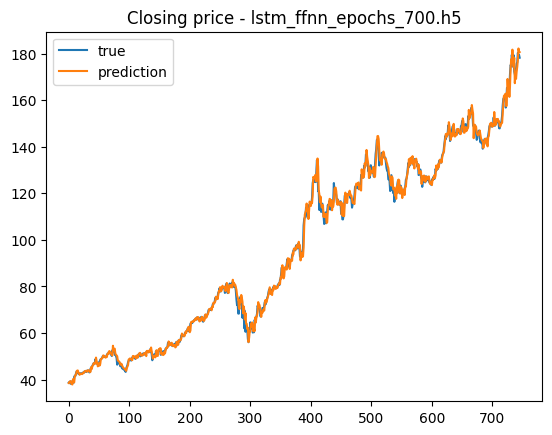

(751, 7)
24/24 [==============================] - 0s 2ms/step


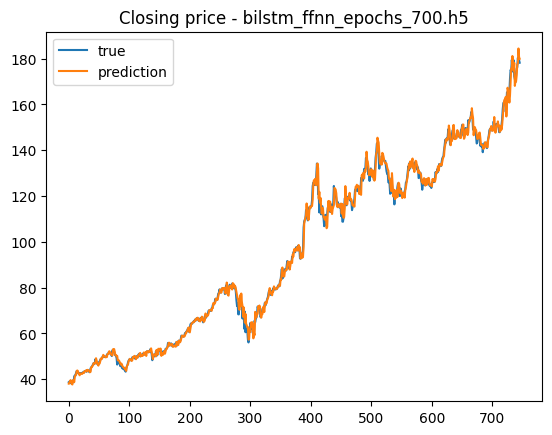

(751, 7)
24/24 [==============================] - 0s 2ms/step


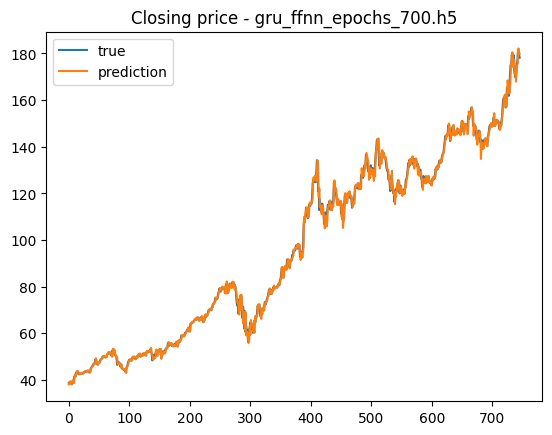

(751, 7)
24/24 [==============================] - 0s 2ms/step


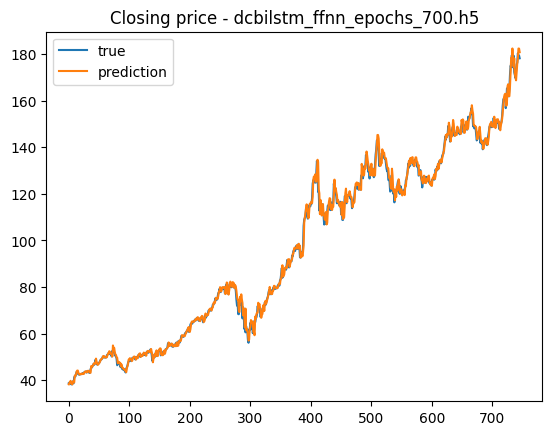

(751, 7)
24/24 [==============================] - 0s 2ms/step


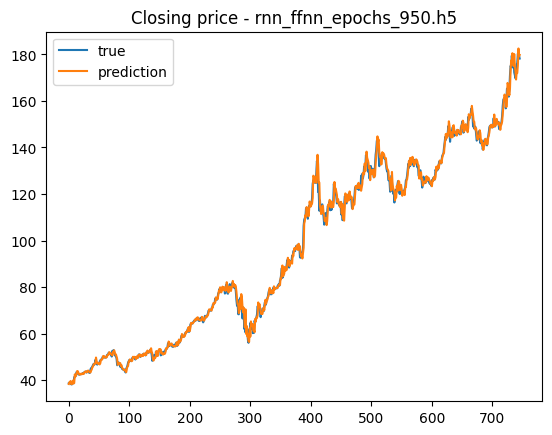

(751, 7)
24/24 [==============================] - 0s 2ms/step


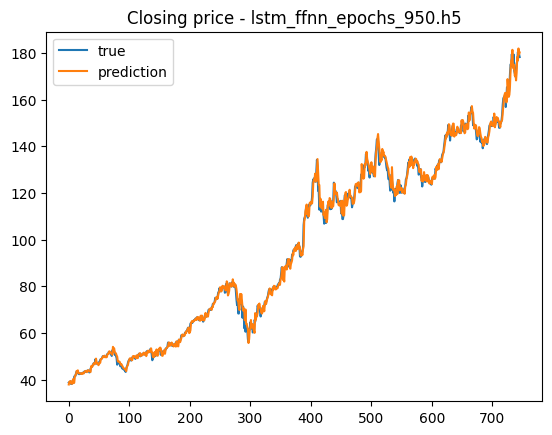

(751, 7)
24/24 [==============================] - 0s 2ms/step


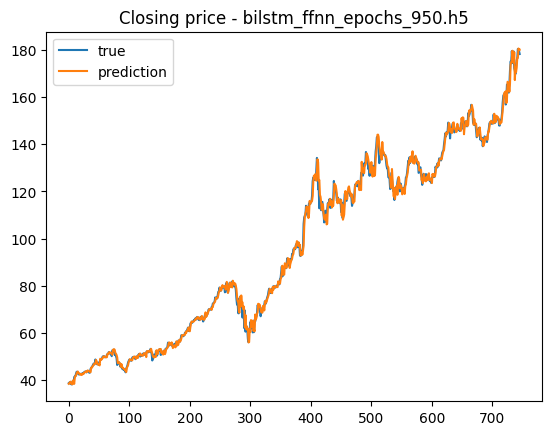

(751, 7)
24/24 [==============================] - 0s 2ms/step


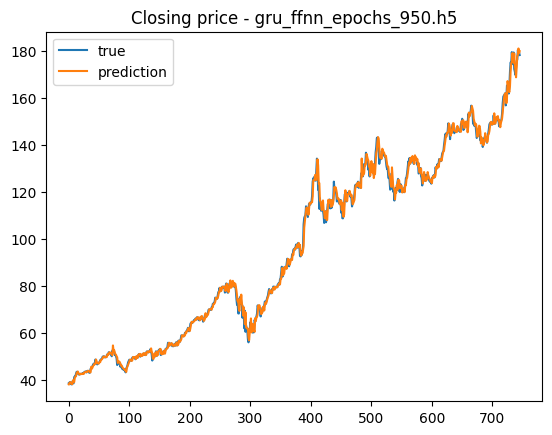

(751, 7)
24/24 [==============================] - 0s 2ms/step


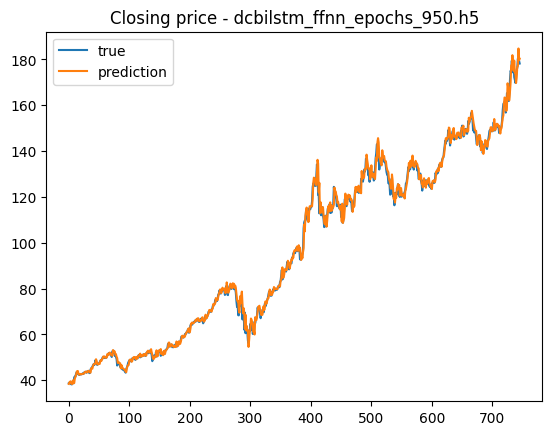

(751, 7)
24/24 [==============================] - 0s 1ms/step


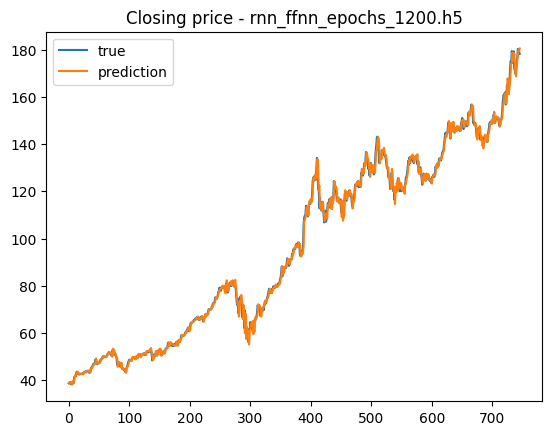

(751, 7)
24/24 [==============================] - 0s 2ms/step


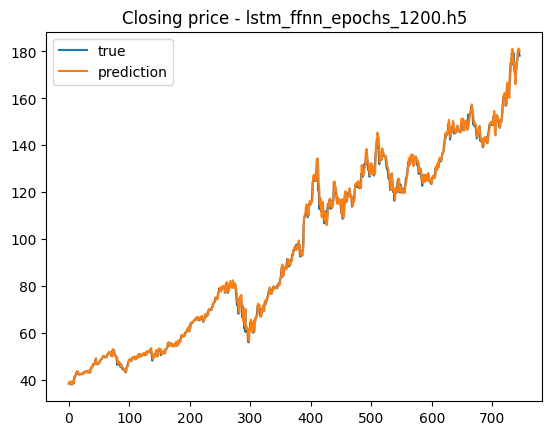

(751, 7)
24/24 [==============================] - 0s 2ms/step


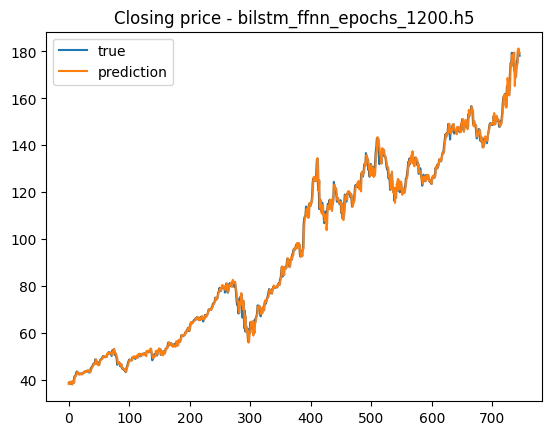

(751, 7)
24/24 [==============================] - 0s 2ms/step


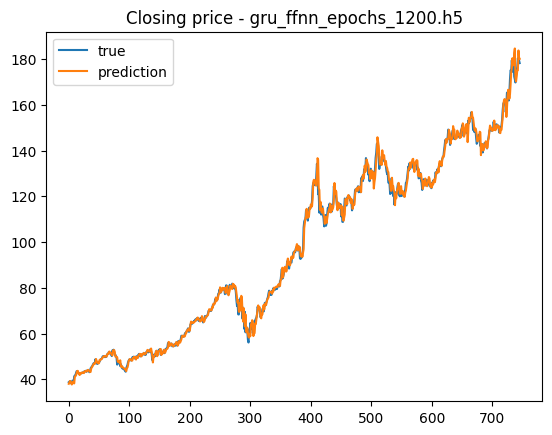

(751, 7)
24/24 [==============================] - 0s 2ms/step


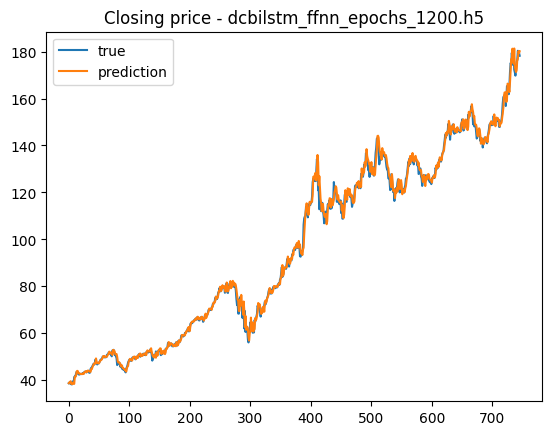

(751, 7)
24/24 [==============================] - 0s 2ms/step


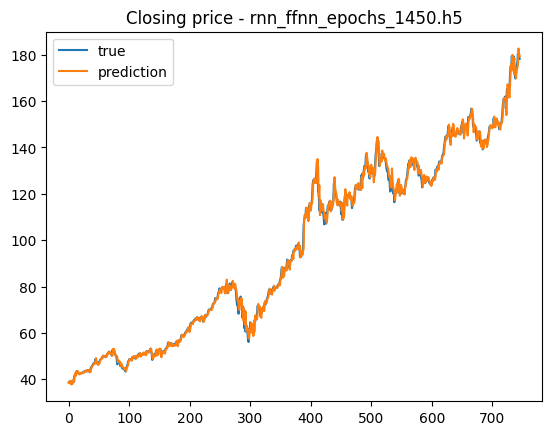

(751, 7)
24/24 [==============================] - 0s 2ms/step


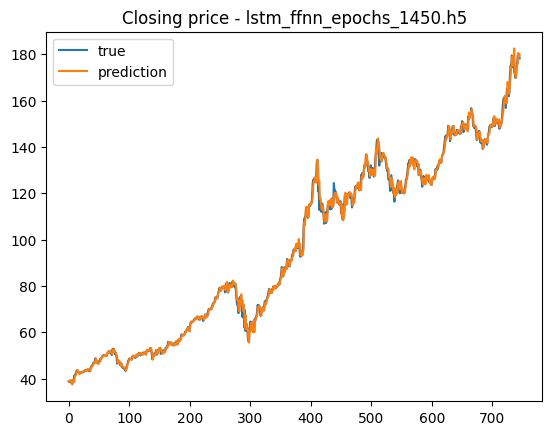

(751, 7)
24/24 [==============================] - 0s 2ms/step


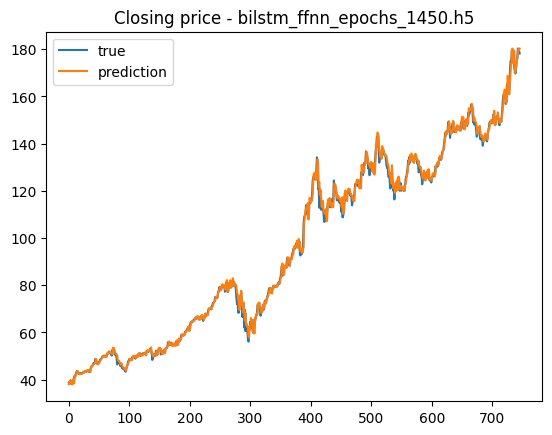

(751, 7)
24/24 [==============================] - 0s 2ms/step


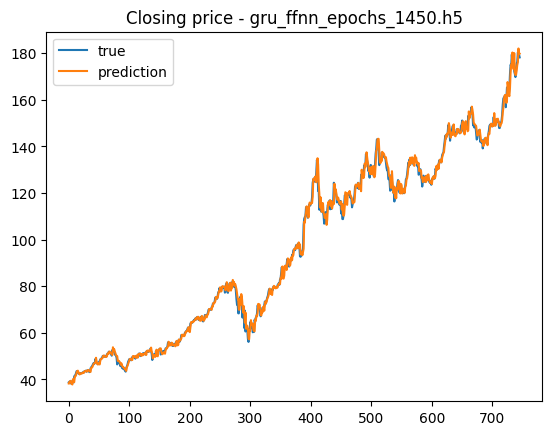

(751, 7)
24/24 [==============================] - 0s 2ms/step


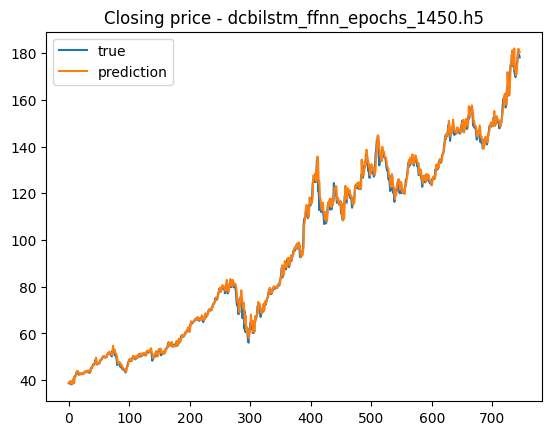

(751, 7)
24/24 [==============================] - 0s 2ms/step


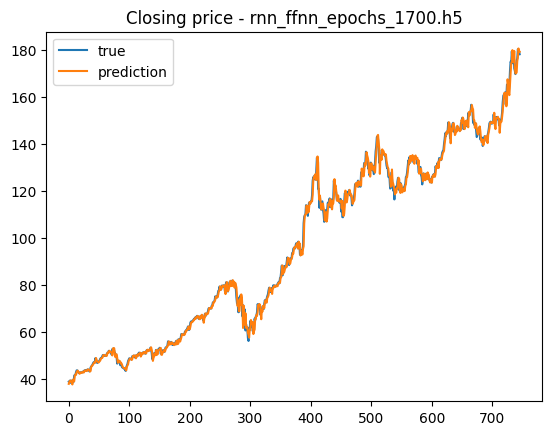

(751, 7)
24/24 [==============================] - 0s 2ms/step


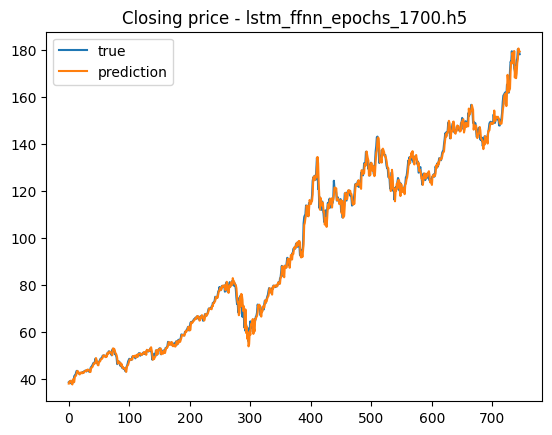

(751, 7)
24/24 [==============================] - 0s 2ms/step


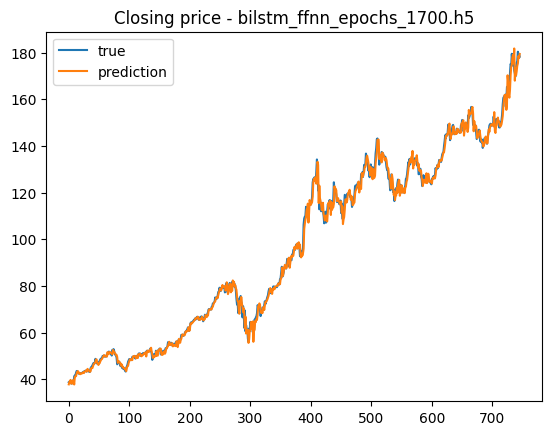

(751, 7)
24/24 [==============================] - 0s 2ms/step


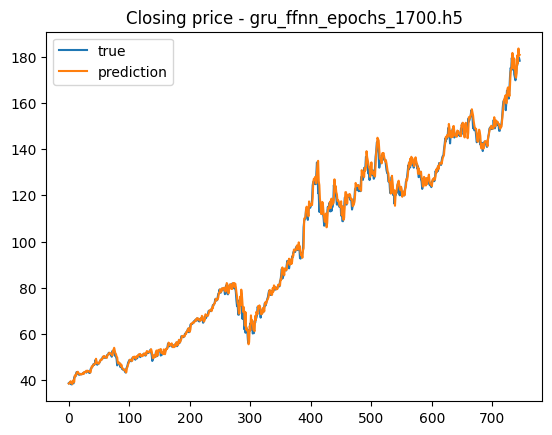

(751, 7)
24/24 [==============================] - 0s 2ms/step


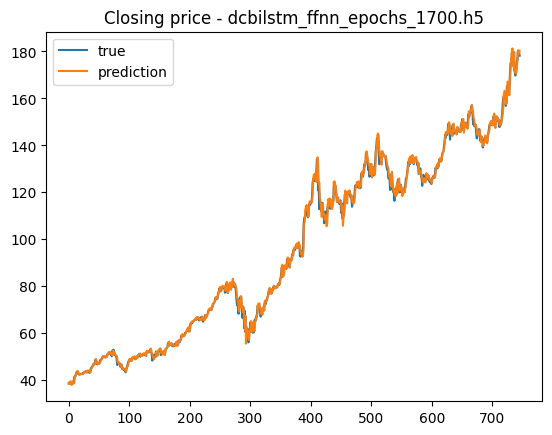

(751, 7)
24/24 [==============================] - 0s 2ms/step


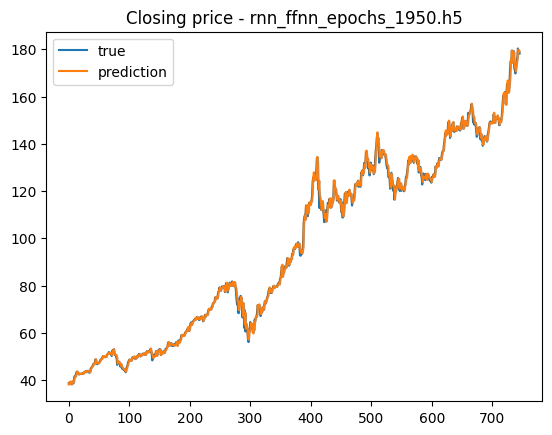

(751, 7)
24/24 [==============================] - 0s 2ms/step


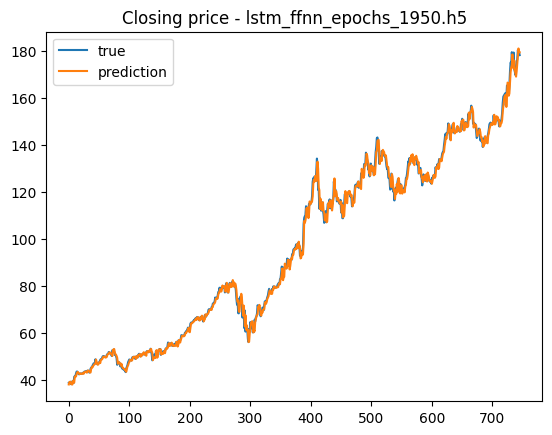

(751, 7)
24/24 [==============================] - 0s 2ms/step


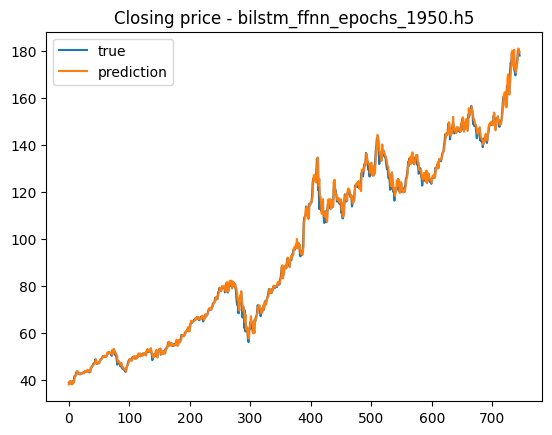

(751, 7)
24/24 [==============================] - 0s 2ms/step


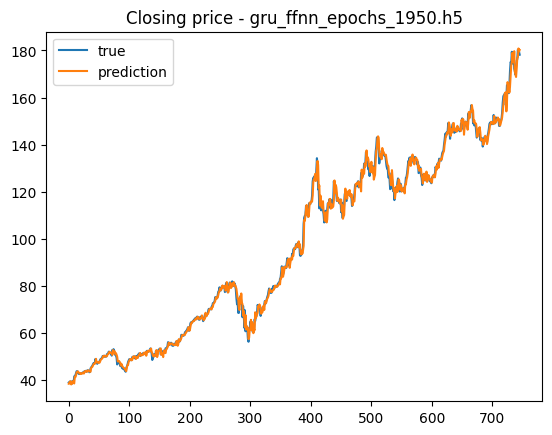

(751, 7)
24/24 [==============================] - 0s 2ms/step


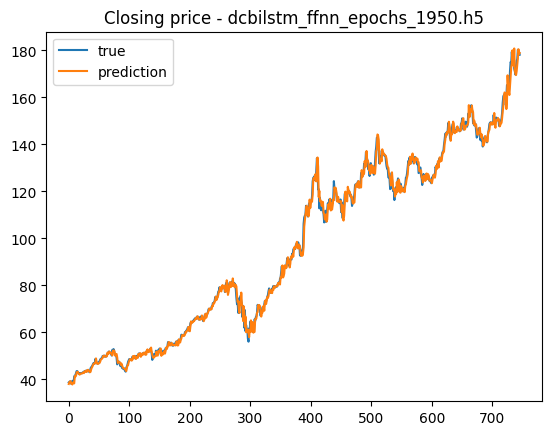

In [15]:
epochs = [200, 450, 700, 950, 1200, 1450, 1700, 1950]
file_names = ['rnn_ffnn', 'lstm_ffnn', 'bilstm_ffnn', 'gru_ffnn', 'dcbilstm_ffnn']
metrics = ['mse', 'mae', 'mape', 'rmse', 'ar']

for epoch in epochs:
    # A table start here
    table = []
    index = []
    for file_name in file_names:
        model_file = "{0}_epochs_{1}.h5".format(file_name, epoch)
        index.append(model_file)
        row = load_file(model_file)
        table.append(row)
    result = pd.DataFrame(table, columns=metrics, index=index)
    result.to_excel("{}.xlsx".format(epoch))